In [1]:
import matplotlib
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
import sys
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
datapath = "/home/tgroves/projects/gpu-comm/results/summit/validation/"


We need to extract the message size, and the time spent in each communication for a file.

Some of the gets are local gets.  We can tell because the bandwidth is 10X theoretical:

4 Node:

RANK(0) 0'th sync is 0.000043 (386.999815 GB/s, FAST)

RANK(3) 1'th sync is 0.000042 (399.847851 GB/s, FAST)

9 Node:

RANK(0) 0'th sync is 0.000049 (151.669830 GB/s, FAST)

RANK(4) 2'th sync is 0.000053 (141.170472 GB/s, FAST)

RANK(8) 1'th sync is 0.000048 (156.615481 GB/s, FAST)

16 Node:

RANK(15) 1'th sync is 0.000036 (118.019753 GB/s, FAST)

RANK(0) 0'th sync is 0.000034 (123.645540 GB/s, FAST)

RANK(5) 3'th sync is 0.000034 (123.536287 GB/s, FAST)

RANK(10) 2'th sync is 0.000034 (122.486464 GB/s, FAST)

In [14]:
#Returns communication time in nanoseconds
#If our application issues single messages, i.e. not throughput or message rate bound.
def timeToGetMessageSummit(m, h_or_d="default", verbose=False):
    #LogGOP parameter values NVSHMEM Host Initiated (ns)
    L_nvshmem_hi = 530
    o_nvshmem_hi = 247
    O_nvshmem_hi = 0.067 * m
    g_nvshmem_hi = 5
    G_nvshmem_hi = m / NETWORKBWGBPS
    S_nvshmem_hi = 0

    #LogGOP parameter values NVSHMEM Dev. Initiated (ns)
    L_nvshmem_di = 530
    o_nvshmem_di = 237
    O_nvshmem_di = 0
    g_nvshmem_di = 5
    G_nvshmem_di = m / NETWORKBWGBPS
    S_nvshmem_di = 4570
    
    #LogGOP parameter values IB verbs and DRAM (ns)
    L_nvshmem_dram = 280
    o_nvshmem_dram = 1400
    O_nvshmem_dram = 0.081 * m
    g_nvshmem_dram = 5
    G_nvshmem_dram = m / NETWORKBWGBPS
    
    if h_or_d == "d":
        if verbose:
            print("2L:{} 4o:{} 4g:{} 2G:{} 2S:{}".format(2*L_nvshmem_di , 4*o_nvshmem_di , 4*g_nvshmem_di , 2*G_nvshmem_di, 2*S_nvshmem_di))
        return 2*L_nvshmem_di + 4*o_nvshmem_di + 4*g_nvshmem_di + 2*G_nvshmem_di + 2*S_nvshmem_di

    elif h_or_d == "h":
        if verbose:
            print("2L:{} 4o:{} 2O:{} 4g:{} 2G:{} KernelLaunch:{}".format(2*L_nvshmem_hi , 4*o_nvshmem_hi , 2*O_nvshmem_hi , 4*g_nvshmem_hi , 2*G_nvshmem_hi , (GPUKERNELUS * 1000)))
        return 2*L_nvshmem_hi + 4*o_nvshmem_hi + 4*g_nvshmem_hi + max([2*G_nvshmem_hi,2*O_nvshmem_hi]) + (GPUKERNELUS * 1000)
        #return 2*L_nvshmem_hi + 4*o_nvshmem_hi + 4*g_nvshmem_hi + 2*G_nvshmem_hi + 2*O_nvshmem_hi + (GPUKERNELUS * 1000)

    #default MPI performance
    else:
        if verbose:
            print("L:{} o:{} O:{} g:{} G:{}".format(L_nvshmem_dram , o_nvshmem_dram , O_nvshmem_dram , g_nvshmem_dram , G_nvshmem_dram ))
        return L_nvshmem_dram + o_nvshmem_dram + O_nvshmem_dram + g_nvshmem_dram + G_nvshmem_dram

In [10]:
#Returns communication time in nanoseconds
#If our application issues single messages, i.e. not throughput or message rate bound.
def timeToGetMessageSummitPipelined(m, h_or_d="default", verbose=False):
    #LogGOP parameter values NVSHMEM Host Initiated (ns)
    L_nvshmem_hi = 0
    o_nvshmem_hi = 0
    O_nvshmem_hi = (624 * m**(-1.09))
    g_nvshmem_hi = 5
    G_nvshmem_hi = m / NETWORKBWGBPS
    S_nvshmem_hi = 0
    #LogGOP parameter values NVSHMEM Dev. Initiated (ns)
    L_nvshmem_di = 0
    o_nvshmem_di = 0
    O_nvshmem_di = 1411 * m**(-0.781)
    g_nvshmem_di = 5
    G_nvshmem_di = m / NETWORKBWGBPS
    
    #LogGOP parameter values IB verbs and DRAM (ns)
    L_nvshmem_dram = 0
    o_nvshmem_dram = 0
    O_nvshmem_dram = 290 * m**(-1.15)
    g_nvshmem_dram = 5
    G_nvshmem_dram = m / NETWORKBWGBPS
    
    if h_or_d == "d":
        if verbose:
            print("L:{} o:{} O:{} g:{} G:{}".format(L_nvshmem_di , o_nvshmem_di , O_nvshmem_di , g_nvshmem_di , G_nvshmem_di))
        return L_nvshmem_di + o_nvshmem_di + max([O_nvshmem_di, (g_nvshmem_di + G_nvshmem_di)])
        #return L_nvshmem_di + o_nvshmem_di + O_nvshmem_di + g_nvshmem_di + G_nvshmem_di
                    
    elif h_or_d == "h":
        if verbose:
            print("L:{} o:{} O:{} g:{} G:{} KernelLaunch:{}".format(L_nvshmem_hi , o_nvshmem_hi , O_nvshmem_hi , g_nvshmem_hi , G_nvshmem_hi , (GPUKERNELUS * 1000)))
        return L_nvshmem_hi + o_nvshmem_hi + max([O_nvshmem_hi, (g_nvshmem_hi + G_nvshmem_hi)])
    #default MPI performance
    else:
        if verbose:
            print("L:{} o:{} O:{} g:{} G:{}".format(L_nvshmem_dram , o_nvshmem_dram , O_nvshmem_dram , g_nvshmem_dram , G_nvshmem_dram ))
        return L_nvshmem_dram + o_nvshmem_dram + max([O_nvshmem_dram, (g_nvshmem_dram + G_nvshmem_dram)])

Chart will show the impact of pipelined vs single message for varied message size.  
series will be host initiated X 10, 25 and 50% communication X single message and pipelined model

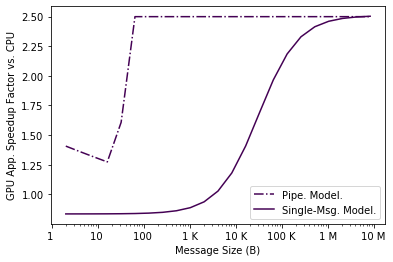

In [15]:
import matplotlib.pylab as pl

CPUFLOPS = 2
GPUFLOPS = 10
GPUKERNELUS = 5
NETWORKBWGBPS = 12.5
COMPSCALING = GPUFLOPS/CPUFLOPS

#Things to vary

def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    count = 0
    prefix = ["", "K", "M", "G", "T"]
    while x >= 1000:
        count += 1
        x = x/1000
    return '%1i %s' % (x, prefix[count])

fig, ax = plt.subplots()
n = 4
colors = pl.cm.viridis(np.linspace(0,1,n))
color = 0
lines = ['-', '--', '-.']
h_or_d = 'h'
ys = {}
xs = [2**j for j in range(1,24)]
for comm_frac in [0.25]:
    ys["single_{}".format(comm_frac)] = []
    ys["pipelined_{}".format(comm_frac)] = []
    for x in xs:
        #This is for fixed problem size model
        comp_frac = 1-comm_frac
        cpu_time = comp_frac + comm_frac
        gpu_time_comm = (timeToGetMessageSummit(x, h_or_d)/timeToGetMessageSummit(x))
        gpu_time_comp = CPUFLOPS/GPUFLOPS
        gpu_time = gpu_time_comm * comm_frac + gpu_time_comp * comp_frac 
        #print("{}, {}".format(idx_i,idx_j))
        ys["single_{}".format(comm_frac)] += [cpu_time/gpu_time]
        
        cpu_time = comp_frac + comm_frac
        gpu_time_comm = (timeToGetMessageSummitPipelined(x, h_or_d)/timeToGetMessageSummitPipelined(x))
        gpu_time_comp = CPUFLOPS/GPUFLOPS
        gpu_time = gpu_time_comm * comm_frac + gpu_time_comp * comp_frac 
        #print("{}, {}".format(idx_i,idx_j))
        ys["pipelined_{}".format(comm_frac)] += [cpu_time/gpu_time]
    ax.plot(xs,ys["pipelined_{}".format(comm_frac)], color=colors[color], ls='-.', label="Pipe. Model.")
    ax.plot(xs,ys["single_{}".format(comm_frac)], color=colors[color], ls='-', label="Single-Msg. Model.")
    color += 1
#plt.ylim(bottom=0.00001, top=0.002)
ax.set_xscale('log')
plt.legend(ncol=1)
ax.set_ylabel("GPU App. Speedup Factor vs. CPU")
ax.set_xlabel("Message Size (B)")
#ax.set_title("Model Validation on 4 Node GEMM Operations\n Non-overlapping Comm./Comp.")
formatter = plt.FuncFormatter(log_10_product)
ax.xaxis.set_major_formatter(formatter)
plt.show()
fig.tight_layout()
fig.savefig("SingleVsPipelined.png")

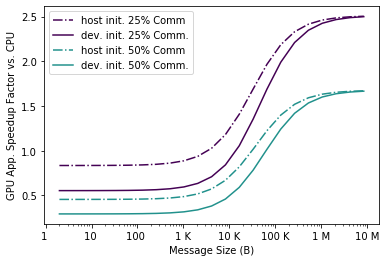

In [16]:
import matplotlib.pylab as pl

CPUFLOPS = 2
GPUFLOPS = 10
GPUKERNELUS = 5
NETWORKBWGBPS = 12.5
COMPSCALING = GPUFLOPS/CPUFLOPS

#Things to vary

def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    count = 0
    prefix = ["", "K", "M", "G", "T"]
    while x >= 1000:
        count += 1
        x = x/1000
    return '%1i %s' % (x, prefix[count])

fig, ax = plt.subplots()
n = 3
colors = pl.cm.viridis(np.linspace(0,1,n))
color = 0
lines = ['-', '--', '-.']
ys = {}
xs = [2**j for j in range(1,24)]
for comm_frac in [0.25, 0.5]:
    ys["host_{}".format(comm_frac)] = []
    ys["device_{}".format(comm_frac)] = []
    for x in xs:
        #This is for fixed problem size model
        comp_frac = 1-comm_frac
        cpu_time = comp_frac + comm_frac
        gpu_time_comm = (timeToGetMessageSummit(x, 'h')/timeToGetMessageSummit(x))
        gpu_time_comp = CPUFLOPS/GPUFLOPS
        gpu_time = gpu_time_comm * comm_frac + gpu_time_comp * comp_frac 
        #print("{}, {}".format(idx_i,idx_j))
        ys["host_{}".format(comm_frac)] += [cpu_time/gpu_time]
        
        cpu_time = comp_frac + comm_frac
        gpu_time_comm = (timeToGetMessageSummit(x, 'd')/timeToGetMessageSummit(x))
        gpu_time_comp = CPUFLOPS/GPUFLOPS
        gpu_time = gpu_time_comm * comm_frac + gpu_time_comp * comp_frac 
        #print("{}, {}".format(idx_i,idx_j))
        ys["device_{}".format(comm_frac)] += [cpu_time/gpu_time]
    ax.plot(xs,ys["host_{}".format(comm_frac)], color=colors[color], ls='-.', label="host init. {}% Comm".format(int(comm_frac*100)))
    ax.plot(xs,ys["device_{}".format(comm_frac)], color=colors[color], ls='-', label="dev. init. {}% Comm.".format(int(comm_frac*100)))
    color += 1
#plt.ylim(bottom=0.00001, top=0.002)
ax.set_xscale('log')
plt.legend(ncol=1)
ax.set_ylabel("GPU App. Speedup Factor vs. CPU")
ax.set_xlabel("Message Size (B)")
#ax.set_title("Model Validation on 4 Node GEMM Operations\n Non-overlapping Comm./Comp.")
formatter = plt.FuncFormatter(log_10_product)
ax.xaxis.set_major_formatter(formatter)
plt.show()
fig.tight_layout()
fig.savefig("HostvsDev.png")

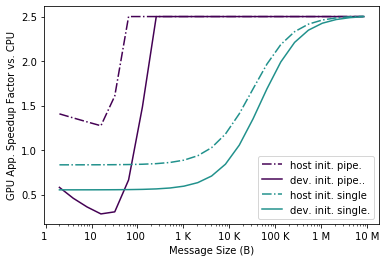

In [17]:
import matplotlib.pylab as pl

CPUFLOPS = 2
GPUFLOPS = 10
GPUKERNELUS = 5
NETWORKBWGBPS = 12.5
COMPSCALING = GPUFLOPS/CPUFLOPS

#Things to vary

def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    count = 0
    prefix = ["", "K", "M", "G", "T"]
    while x >= 1000:
        count += 1
        x = x/1000
    return '%1i %s' % (x, prefix[count])

fig, ax = plt.subplots()
n = 3
colors = pl.cm.viridis(np.linspace(0,1,n))
color = 0
lines = ['-', '--', '-.']
ys = {}
xs = [2**j for j in range(1,24)]
comm_frac = 0.25
for model in ['p', 's']:
    ys["host_{}_{}".format(comm_frac, model)] = []
    ys["device_{}_{}".format(comm_frac, model)] = []
    for x in xs:
        #This is for fixed problem size model
        comp_frac = 1-comm_frac
        cpu_time = comp_frac + comm_frac
        if model == 's':
            gpu_time_comm = (timeToGetMessageSummit(x, 'h')/timeToGetMessageSummit(x))
        else:
            gpu_time_comm = (timeToGetMessageSummitPipelined(x, 'h')/timeToGetMessageSummitPipelined(x))
        gpu_time_comp = CPUFLOPS/GPUFLOPS
        gpu_time = gpu_time_comm * comm_frac + gpu_time_comp * comp_frac 
        #print("{}, {}".format(idx_i,idx_j))
        ys["host_{}_{}".format(comm_frac, model)] += [cpu_time/gpu_time]
        
        cpu_time = comp_frac + comm_frac
        if model == 's':
            gpu_time_comm = (timeToGetMessageSummit(x, 'd')/timeToGetMessageSummit(x))
        if model == 'p':
            gpu_time_comm = (timeToGetMessageSummitPipelined(x, 'd')/timeToGetMessageSummitPipelined(x))
        gpu_time_comp = CPUFLOPS/GPUFLOPS
        gpu_time = gpu_time_comm * comm_frac + gpu_time_comp * comp_frac 
        #print("{}, {}".format(idx_i,idx_j))
        ys["device_{}_{}".format(comm_frac, model)] += [cpu_time/gpu_time]
    ax.plot(xs,ys["host_{}_{}".format(comm_frac, model)], color=colors[color], ls='-.', label="host init. {}".format(("single" if model == 's' else "pipe.")))
    ax.plot(xs,ys["device_{}_{}".format(comm_frac, model)], color=colors[color], ls='-', label="dev. init. {}.".format(("single" if model == 's' else "pipe.")))
    color += 1
#plt.ylim(bottom=0.00001, top=0.002)
ax.set_xscale('log')
plt.legend(ncol=1)
ax.set_ylabel("GPU App. Speedup Factor vs. CPU")
ax.set_xlabel("Message Size (B)")
#ax.set_title("Model Validation on 4 Node GEMM Operations\n Non-overlapping Comm./Comp.")
formatter = plt.FuncFormatter(log_10_product)
ax.xaxis.set_major_formatter(formatter)
plt.show()
fig.tight_layout()
fig.savefig("HostvsDev.png")

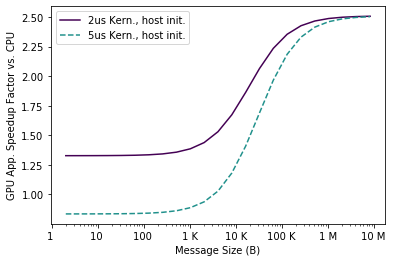

In [18]:
import matplotlib.pylab as pl

CPUFLOPS = 2
GPUFLOPS = 10
GPUKERNELUS = 2
NETWORKBWGBPS = 12.5
COMPSCALING = GPUFLOPS/CPUFLOPS

#Things to vary

def log_10_product(x, pos):
    """The two args are the value and tick position.
    Label ticks with the product of the exponentiation"""
    count = 0
    prefix = ["", "K", "M", "G", "T"]
    while x >= 1000:
        count += 1
        x = x/1000
    return '%1i %s' % (x, prefix[count])

fig, ax = plt.subplots()
n = 3
colors = pl.cm.viridis(np.linspace(0,1,n))
color = 0
lines = ['-', '--', '-.']
ys = {}
xs = [2**j for j in range(1,24)]
comm_frac = 0.25
for kern in [2, 5]:
    GPUKERNELUS = kern
    ys["host_{}".format(kern)] = []
    for x in xs:
        #This is for fixed problem size model
        comp_frac = 1-comm_frac
        cpu_time = comp_frac + comm_frac
        gpu_time_comm = (timeToGetMessageSummit(x, 'h')/timeToGetMessageSummit(x))
        gpu_time_comp = CPUFLOPS/GPUFLOPS
        gpu_time = gpu_time_comm * comm_frac + gpu_time_comp * comp_frac 
        #print("{}, {}".format(idx_i,idx_j))
        ys["host_{}".format(kern)] += [cpu_time/gpu_time]

    ax.plot(xs,ys["host_{}".format(kern)], color=colors[color], ls=lines[color], label="{}us Kern., host init.".format(kern))
    color +=1


#plt.ylim(bottom=0.00001, top=0.002)
ax.set_xscale('log')
plt.legend(ncol=1)
ax.set_ylabel("GPU App. Speedup Factor vs. CPU")
ax.set_xlabel("Message Size (B)")
#ax.set_title("Model Validation on 4 Node GEMM Operations\n Non-overlapping Comm./Comp.")
formatter = plt.FuncFormatter(log_10_product)
ax.xaxis.set_major_formatter(formatter)
plt.show()
fig.tight_layout()
fig.savefig("2vs5Kernel.png")

In [84]:
[x1-x2 for x1, x2 in zip(ys['host_0.25'], ys['device_0.25'])]

[0.2556440396648333,
 0.25566405768023137,
 0.25570407498818637,
 0.25578403475964595,
 0.2559436552996385,
 0.25626170336004916,
 0.25689305123034123,
 0.25813694285759925,
 0.2605509935163126,
 0.2650956141479671,
 0.27313623708576507,
 0.2856172741328754,
 0.2998353574137226,
 0.30342380821033355,
 0.27461376800853876,
 0.20337021422207968,
 0.11096434634215546,
 0.02941446324312924,
 -0.026779024825056563,
 -0.06016488321137503,
 -0.07842592314979058,
 -0.08798489078355898,
 -0.09287646015786688]